In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

# Introduction

The purpose of this notebook is to replicate the model of conductance loss due to xylem damage used in [D.S.Mackay et. al. 2015](https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2015WR017244). The base vunrability curve is a cumulative weibull distribution used in [J.S.Sperry et. al. 2002](https://onlinelibrary.wiley.com/doi/10.1046/j.1365-3040.1998.00287.x).

$$
k(\psi) = k_{max} e^{-(\frac{\psi}{b})^c}
$$

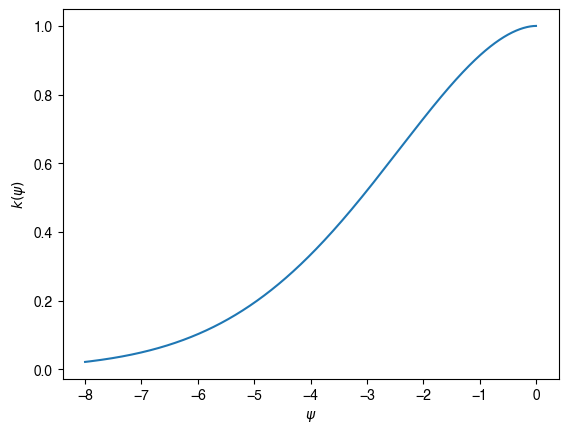

In [2]:
def k(psi, kmax, b, c):
    exponent = -np.power(psi/b, c)
    return kmax * np.exp(exponent)

kmax = 1
b = -3.8 # MPa
c = 1.8

psi_array = np.linspace(0,-8,1000)
k_array = k(psi_array, kmax, b, c)

plt.plot(psi_array, k_array)
plt.xlabel("$\psi$")
plt.ylabel("$k(\psi)$")
plt.show()

# The Papers Model

## Limiting conductance

To model damage to xylem D.S.Mackay et. al. (2015) first describes a simple model where the current conductance is the minimum of the current and all previous conductances. The code bellow impliments this model, denoting the minimum conductance of all previous conductances as $k_{cav}$, and plots the results for a range of previous minimum conductances.

$$
k_i(\psi) = 
\begin{cases}
k(\psi_i), k(\psi_i) < k_{cav}\\
k_{cav}, k(\psi_i) \geq k_{cav}
\end{cases}
$$

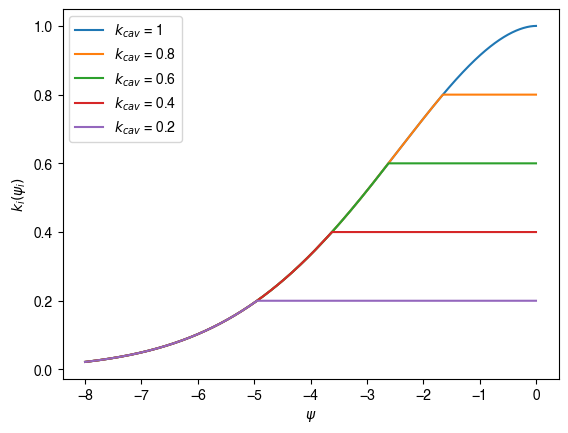

In [3]:
def k_limited(psi, k_max, b, c, k_previous):
    k_out = k(psi, k_max, b, c)
    return np.clip(k_out, 0, k_previous)

k_max = 1
b = -3.8 # MPa
c = 1.8

k_cav_list = k_max * [1, 0.8, 0.6, 0.4, 0.2]

psi_array = np.linspace(0,-8,1000)
k_arrays = []

for k_cav in k_cav_list:
    k_arrays.append(k_limited(psi_array, k_max, b, c, k_cav))

    plt.plot(psi_array, k_arrays[-1], label = "$k_{{cav}}$ = {}".format(str(k_cav)))

plt.xlabel("$\psi$")
plt.ylabel("$k_i(\psi_i)$")
plt.legend()
plt.show()

## Fitting to the new conductance curve

Having created the model above, D.S.Mackay et. al. (2015) create a new cumulative Weibull distribution that reflects the damage to the xylem described above.

The first step in this process is to define the proportional loss of conductance as;

$$
P_i = 1-\frac{k_i(\psi_i)}{k_{cav}}
$$

where $k_i$ comes from the equation for the limited conductance above.

With respect to the new value of the shape parameter the paper states "At a tension correponding to the negative of parameter $b$ we set $b_{cav} = -\psi_i$." (note the minus infront of the water potential is not needed because of the way this code is setup with negative values of b). What this quote is trying to describe is that the new value of $b$ is the water potential at which the preious vunrability curve is equal to $k_{cav}e^{-1}$. This gives the following equation for $b_{cav}$,

$$
b_{cav} = b(1-\ln(\frac{k_{cav}}{k_{max}}))^{1/c}
$$

The only remaining thing to do is find the new value of the shape parameter $c_{cav}$. This is done by finding the value of $c_{cav}$ that minimises;

$$
\frac{(\sum_{i=1}^N P_i k_i')^2}{(\sum_{i=1}^N P_i)^2(\sum_{i=1}^N k_i')^2}
$$

Where;

$$
k_{i}' = k_{cav}e^{-(\frac{\psi_i}{b_{cav}})^{c_{cav}}}
$$

b  -3.47  ->  -3.8393221866366942
c  4.08  ->  14.481020498922193


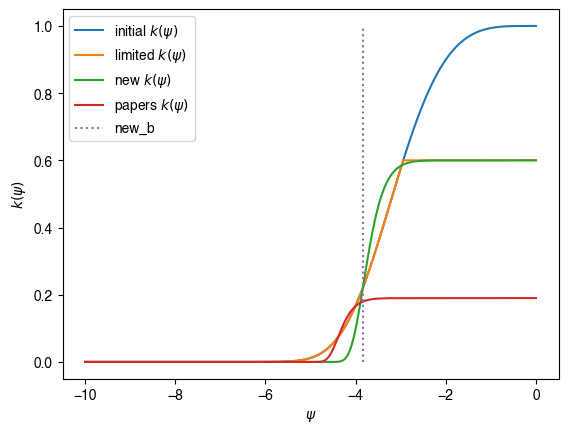

In [4]:
def paper_fit_new_conductance(k_max, b, c, new_k_max, psi_array = np.linspace(0, -8, 1000)):

    # Get the new capped vulnerability curve
    k_target = k_limited(psi_array, k_max, b, c, new_k_max)

    # Calculate the percentage conductance loss
    P_i = 1 - k_target/new_k_max

    b_new = b * np.power(1 - np.log(new_k_max/k_max), 1/c)

    # Define the residual calculation
    def residuals(current_c, *args, **kwargs):

        k_current = k(psi_array, new_k_max, b_new, current_c[0])

        numerator = (np.sum(P_i*k_current))**2

        denominator = (np.sum(P_i)**2)*(np.sum(k_current)**2)
        
        return numerator/denominator

    c_new, cost = optimize.leastsq(residuals, c, args=(c))
    
    return b_new, c_new[0]

kmax = 1
b = -3.47 # MPa
c = 4.08

new_k_max = 0.6 # 0.19

psi_array = np.linspace(0, -10, 1000)

new_b, new_c = paper_fit_new_conductance(k_max, b, c, new_k_max, psi_array)

print("b ", b, " -> ", new_b)
print("c ", c, " -> ", new_c)

plt.plot(psi_array, k(psi_array, k_max, b, c), label = "initial $k(\psi)$")
plt.plot(psi_array, k_limited(psi_array, k_max, b, c, new_k_max), label = "limited $k(\psi)$")
plt.plot(psi_array, k(psi_array, new_k_max, new_b, new_c), label = "new $k(\psi)$")
plt.plot(psi_array, k(psi_array, 0.19, -4.4, 21.1), label = "papers $k(\psi)$")
plt.plot([new_b, new_b], [0,k_max], linestyle = ":", label = "new_b")
plt.legend()
plt.xlabel("$\psi$")
plt.ylabel("$k(\psi)$")
plt.show()

b  -3.47  ->  -4.453445528371475
c  4.08  ->  15.32870677839142


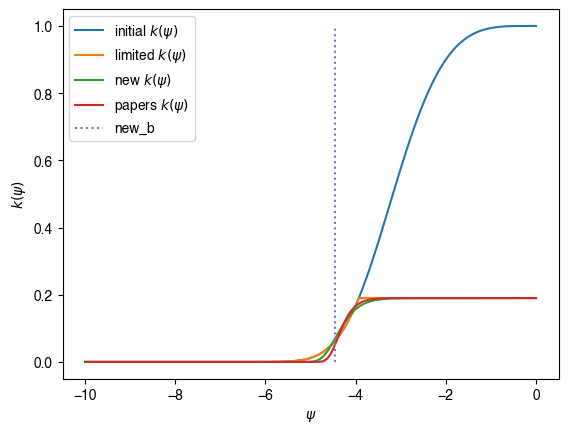

In [5]:
def paper_fit_new_conductance_b_and_c(k_max, b, c, new_k_max, psi_array = np.linspace(0, -8, 1000)):

    # Get the new capped vulnerability curve
    k_target = k_limited(psi_array, k_max, b, c, new_k_max)

    # Calculate the percentage conductance loss
    P_i = 1 - k_target/new_k_max
    
    # Define the residual calculation
    def residuals(current_bc):#, *args, **kwargs):

        k_current = k(psi_array, new_k_max, current_bc[0], current_bc[1])

        return k_current - k_target

    [b_new, c_new], cost = optimize.leastsq(residuals, [b, c])
    
    return b_new, c_new

kmax = 1
b = -3.47 # MPa
c = 4.08

new_k_max = 0.19

psi_array = np.linspace(0, -10, 1000)

new_b, new_c = paper_fit_new_conductance_b_and_c(k_max, b, c, new_k_max, psi_array)

print("b ", b, " -> ", new_b)
print("c ", c, " -> ", new_c)

plt.plot(psi_array, k(psi_array, k_max, b, c), label = "initial $k(\psi)$")
plt.plot(psi_array, k_limited(psi_array, k_max, b, c, new_k_max), label = "limited $k(\psi)$")
plt.plot(psi_array, k(psi_array, new_k_max, new_b, new_c), label = "new $k(\psi)$")
plt.plot(psi_array, k(psi_array, 0.19, -4.4, 21.1), label = "papers $k(\psi)$")
plt.plot([new_b, new_b], [0,k_max], linestyle = ":", label = "new_b")
plt.legend()
plt.xlabel("$\psi$")
plt.ylabel("$k(\psi)$")
plt.show()

## $c$ as a function of $k_{cap}$

Using a fiting method to find $c$ is expensive and would need to be coded in JULES. Lets test to see if there is a clear functional ralation between $c$ and $k_{cap}4 that we can exploit.

$$
c_{new} = c (\frac{b_{new}}{b})^c \frac{k_{max}}{k_{max \, new}} e ^{1 - (\frac{b_{new}}{b})^c}
$$

b  -3.47  ->  -3.8393221866366942
c  4.08  ->  6.164168544965245


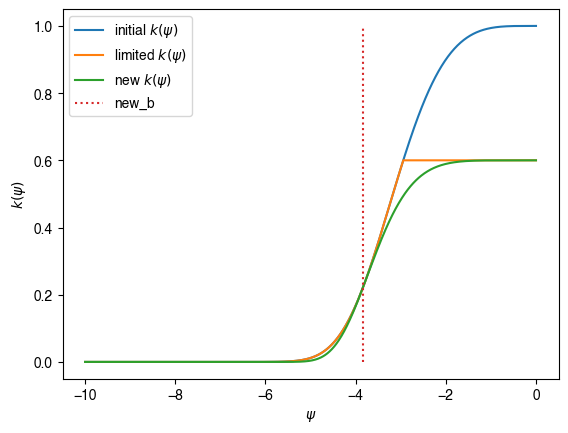

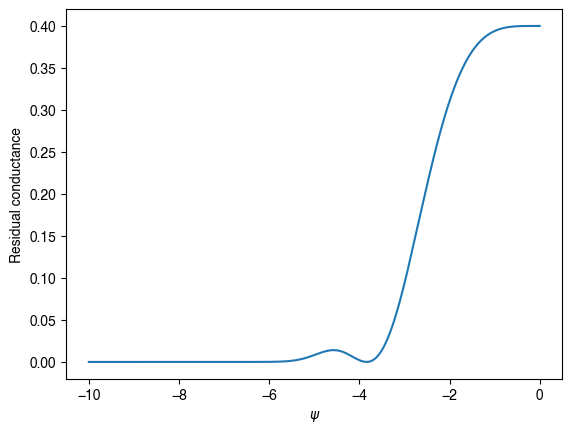

In [6]:
def get_c_from_gradient(k_max, b, c, new_k_max):

    b_new = b*np.power(1 - np.log(new_k_max/k_max),1/c)

    exponent = 1 - np.power(b_new/b, c)
    
    c_new = c * np.power(b_new/b, c) * (k_max/new_k_max) * np.exp(exponent)
    
    return b_new, c_new

kmax = 1
b = -3.47 # MPa
c = 4.08

new_k_max = 0.6

psi_array = np.linspace(0, -10, 1000)

new_b, new_c = get_c_from_gradient(k_max, b, c, new_k_max)

print("b ", b, " -> ", new_b)
print("c ", c, " -> ", new_c)

plt.plot(psi_array, k(psi_array, k_max, b, c), label = "initial $k(\psi)$")
plt.plot(psi_array, k_limited(psi_array, k_max, b, c, new_k_max), label = "limited $k(\psi)$")
plt.plot(psi_array, k(psi_array, new_k_max, new_b, new_c), label = "new $k(\psi)$")
plt.plot([new_b, new_b], [0,k_max], linestyle = ":", label = "new_b")
plt.legend()
plt.xlabel("$\psi$")
plt.ylabel("$k(\psi)$")
plt.show()

plt.plot(psi_array, k(psi_array, k_max, b, c) - k(psi_array, new_k_max, new_b, new_c))
plt.xlabel("$\psi$")
plt.ylabel("Residual conductance")
plt.show()

/var/folders/qd/r8_04ccx1hlf_x0k_jfklmv40000gq/T/ipykernel_83844/744071116.py:2: RuntimeWarning: divide by zero encountered in power
  exponent = -np.power(psi/b, c)


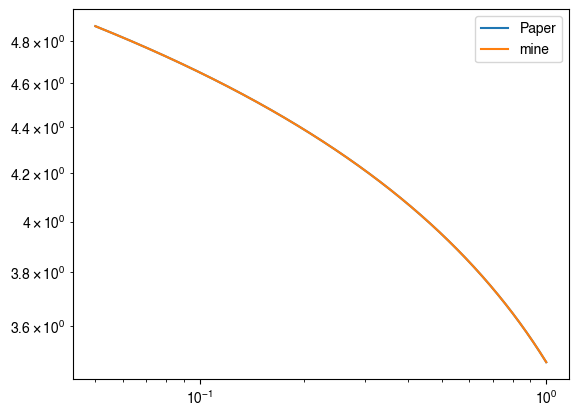

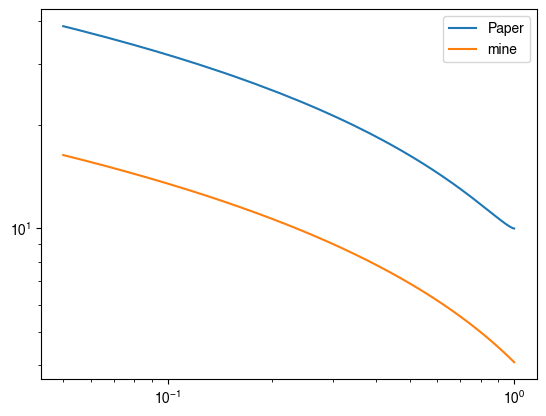

In [7]:
k_max = 1
b = -3.47 # MPa
c = 4.08

N = 1000
k_cap_array = np.linspace(k_max, 0.05*k_max,N)
b_array = np.zeros(N)
c_array = np.zeros(N)

for i in range(N):
    b_array[i], c_array[i] = paper_fit_new_conductance(k_max, b, c, k_cap_array[i])

my_b_array, my_c_array = get_c_from_gradient(k_max, b, c, k_cap_array)

plt.plot(k_cap_array, -b_array, label = 'Paper')
plt.plot(k_cap_array, -my_b_array, label = 'mine')
plt.legend()
plt.loglog()
plt.show()

plt.plot(k_cap_array, c_array, label = 'Paper')
plt.plot(k_cap_array, my_c_array, label = 'mine')
plt.legend()
plt.loglog()
plt.show()

# The Codes Model

In the [code](https://github.com/mdekauwe/TREES-Workshop-2020/tree/main/Model-Code) Martin sent me, the model above has been updated. Below we impliment this newer method to compare it to that in the paper.

The fisrt step is to calculate the PLC at a predawn water potential $\psi_{min}$.

$$
P_o = 100(1 - e^{-(\frac{\psi_{min}}{b})^c})
$$

Where $b$ and $c$ are the current conductance model parameters.

A PLC value is calculated for a range of water potentials,

$$
P_i = 100(1 - e^{-(\frac{\psi_{i}}{b})^c})
$$

$$
P_i =
\begin{cases}
P_o, \psi_i \geq \psi_{min} \\
100(1 - e^{-(\frac{\psi_{i}}{b})^c}), \psi_i < \psi_{min}
\end{cases}
$$

The value of $P_i$ is then normalised with respect to $P_o$ as,

$$
P_i = 100(1-\frac{100 - P_i}{100 - P_o})
$$

The new value of the sensetivity parameter $b_{cav}$ is set to the water potential when the percentage loss of conductance, $P_i$, reaches  $66$.